In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/samantha/QuantUS-Plugins-CEUS/TwoD_CEUS_test
/Users/samantha/QuantUS-Plugins-CEUS


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [2]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [30]:
scan_type = 'mp4'

scan_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p16/p16 wk12/p16_wk12.mp4'
scan_loader_kwargs = {
    'transpose': False
}

In [31]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [32]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [40]:
seg_type = 'nifti'

seg_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p16/p16 wk12/p16_wk12_roi_big.nii.gz'
seg_loader_kwargs = {}

In [41]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

frames = image_data.pixel_data[:,:,:,0]
seg_mask = seg_data.seg_mask

print(f'Segmentation mask shape: {seg_mask.shape}')
print(f'Image data shape: {image_data.pixel_data.shape}')

frame_slider = widgets.IntSlider(
    value=130,
    min=0,
    max=frames.shape[0] - 1,
    step=1,
    description='Frame',
    continuous_update=False,
)
overlay_toggle = widgets.ToggleButton(
    value=False,
    description='Show ROI',
    icon='eye',
)

output = widgets.Output()


def _select_seg_frame(frame_idx: int):
    if seg_mask.ndim == 3 and seg_mask.shape[0] == frames.shape[0]:
        return seg_mask[frame_idx]
    return seg_mask


def _render_frame(change=None):
    with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(frames[frame_slider.value], cmap='gray')
        if overlay_toggle.value:
            ax.imshow(_select_seg_frame(frame_slider.value), alpha=0.35, cmap='Reds')
        ax.set_title(f"{seg_data.seg_name} - Frame {frame_slider.value}")
        ax.axis('off')
        plt.show()


frame_slider.observe(_render_frame, names='value')
overlay_toggle.observe(_render_frame, names='value')

controls = widgets.HBox([frame_slider, overlay_toggle])
display(controls, output)

_render_frame()


Segmentation mask shape: (1472, 1962)
Image data shape: (879, 1472, 1962, 3)


Output()

# Generating T0 map using Segmentation Mask and Pixel data.

In [43]:
image_data.pixel_data.shape

(879, 1472, 1962, 3)

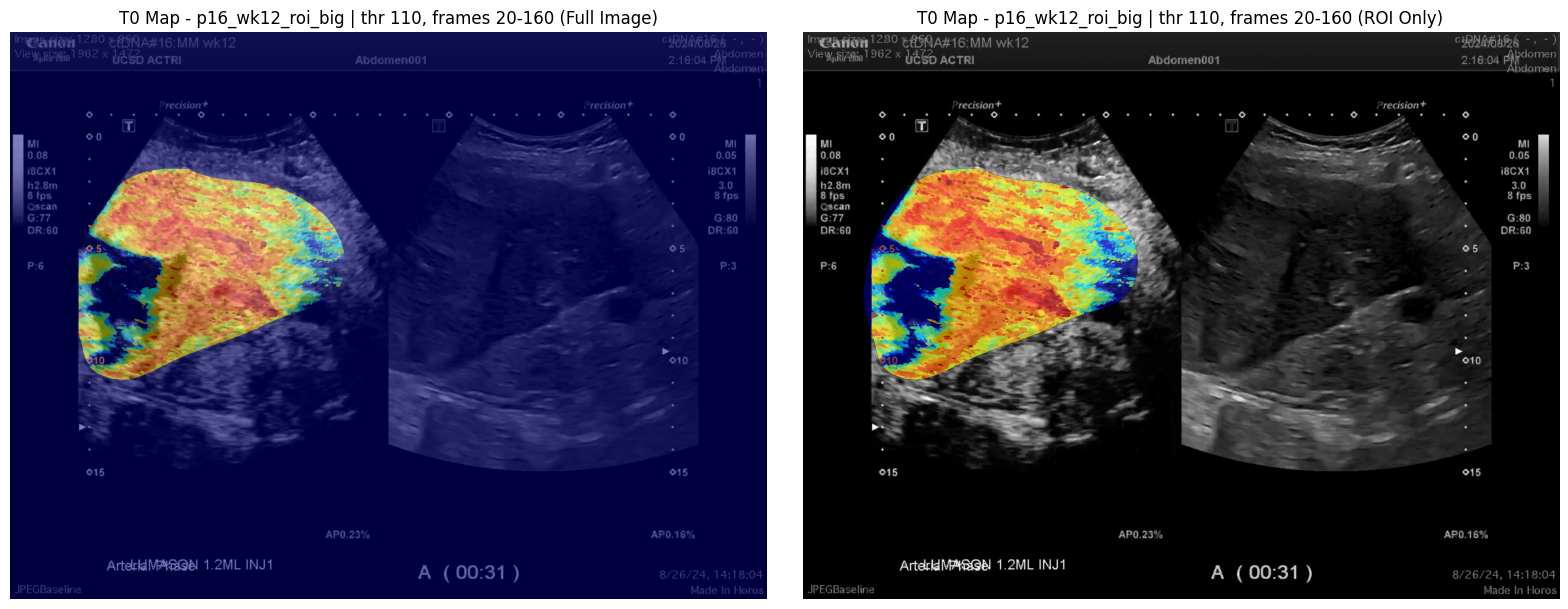


T0 Map Statistics:
  mean_t0: 93.88
  median_t0: 101.00
  std_t0: 26.91
  min_t0: 1.00
  max_t0: 140.00
  coverage: 87.78


In [44]:
from TwoD_CEUS_test.T0_map import generate_t0_map, get_t0_statistics, mask_t0_map

# Generate the T0 map
threshold = 110
start_frame = 20
end_frame = 160

t0_map = generate_t0_map(
    image_data.pixel_data[:,:,:,0],  # Use the first channel if multi-channel
    seg_data.seg_mask,
    threshold=threshold,
    start_frame=start_frame,
    end_frame=end_frame  
)

# Mask the T0 map to show only ROI
masked_t0_map = mask_t0_map(t0_map, seg_data.seg_mask)

# Visualize it
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Original with full overlay
single_image = image_data.pixel_data[250,:,:,0]
axes[0].imshow(single_image, cmap='gray')
axes[0].imshow(t0_map, alpha=0.5, cmap='jet')
axes[0].set_title(f'T0 Map - {seg_data.seg_name} | thr {threshold}, frames {start_frame}-{end_frame} (Full Image)')
axes[0].axis('off')

# Right: Masked to show only ROI
axes[1].imshow(single_image, cmap='gray')
axes[1].imshow(masked_t0_map, alpha=0.7, cmap='jet')
axes[1].set_title(f'T0 Map - {seg_data.seg_name} | thr {threshold}, frames {start_frame}-{end_frame} (ROI Only)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Get statistics
stats = get_t0_statistics(t0_map, seg_data.seg_mask)
print("\nT0 Map Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value:.2f}")